In [1]:
%cd "/content/drive/MyDrive/Neural project/"

/content/drive/MyDrive/Neural project


In [2]:
!pwd

/content/drive/MyDrive/Neural project


#Tensorflow version and GPU (OPTIONAL)

In [3]:
# Check tensorflow version and GPU availability
import tensorflow as tf
print('tf version:', tf.__version__)
print('gpu:', tf.config.list_physical_devices('GPU'))

tf version: 2.8.0
gpu: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


#Global Constants

In [4]:
IMG_DIMEN = 170
N_COLORS = 3   

In [5]:
import cv2

#Reading Dataset Function

In [6]:
from tqdm import tqdm
import numpy as np
import os

def read_data(dir_path):
    X = []
    y = []
    y_map = {'cats': 0, 'dogs': 1}
    for class_name in y_map.keys():
        subdir_path = os.path.join(dir_path, class_name)
        filenames = os.listdir(subdir_path)
        for fname in tqdm(filenames):
            if fname.endswith('.jpg'):
                img_path = os.path.join(subdir_path, fname)
                img = cv2.imread(img_path)
                img = cv2.resize(img, dsize=(IMG_DIMEN, IMG_DIMEN))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = img.reshape((1, IMG_DIMEN, IMG_DIMEN, N_COLORS))
                X.append(img)
                y.append(y_map[class_name])
    X = np.vstack(X).astype('float32')/255.0
    y = np.array(y).astype('int32')
    return X, y

#We read data in x test ,y test

In [7]:
X, y = read_data('data/training_set')

100%|██████████| 4006/4006 [00:37<00:00, 108.14it/s]


In [8]:
print(X.shape)
print(y.shape)

(8005, 170, 170, 3)
(8005,)


In [9]:
X_test , y_test = read_data('data/test_set')

100%|██████████| 1013/1013 [00:09<00:00, 112.06it/s]


In [10]:
print(X_test.shape)
print(y_test.shape)

(2023, 170, 170, 3)
(2023,)


#Splitting X,y into train and validation

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.35, random_state=0)

In [12]:
print(X_train.shape)
print(y_train.shape)
print('--------------')
print(X_val.shape)
print(y_val.shape)

(5203, 170, 170, 3)
(5203,)
--------------
(2802, 170, 170, 3)
(2802,)


#Visualising and example image

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

def imshow(img):
    plt.figure(figsize=(6, 6))
    if N_COLORS == 3:
        plt.imshow(img)
    elif N_COLORS == 1:
         plt.imshow(img, cmap='gray')
    plt.show()

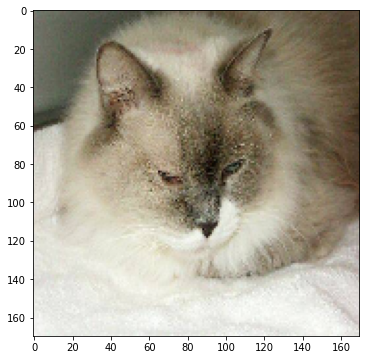

In [14]:
imshow(X_train[3])

#Bulding CNN

In [15]:
import tensorflow as tf
model = tf.keras.models.Sequential([
tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_DIMEN, IMG_DIMEN, N_COLORS)),
tf.keras.layers.MaxPooling2D(2, 2),
tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
tf.keras.layers.MaxPooling2D(2,2),
tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
tf.keras.layers.MaxPooling2D(2,2),
tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
tf.keras.layers.MaxPooling2D(2,2),
tf.keras.layers.Dropout(0.4),
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(128, activation='relu'),
tf.keras.layers.Dropout(0.3),
tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',
                 optimizer='adam',
                 metrics=['acc'])

#Training and Validation

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    'saved-model/best-model', monitor='val_loss', mode='min', 
    save_weights_only=True, save_best_only=True, verbose=1
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=50,
    callbacks=[checkpoint]
)

Epoch 1/50
163/163 [==============================] - ETA: 0s - loss: 0.6915 - acc: 0.5339
Epoch 1: val_loss improved from inf to 0.68502, saving model to saved-model/best-model
163/163 [==============================] - 25s 92ms/step - loss: 0.6915 - acc: 0.5339 - val_loss: 0.6850 - val_acc: 0.5310
Epoch 2/50
163/163 [==============================] - ETA: 0s - loss: 0.6794 - acc: 0.5585
Epoch 2: val_loss improved from 0.68502 to 0.68450, saving model to saved-model/best-model
163/163 [==============================] - 13s 80ms/step - loss: 0.6794 - acc: 0.5585 - val_loss: 0.6845 - val_acc: 0.5310
Epoch 3/50
162/163 [============================>.] - ETA: 0s - loss: 0.6638 - acc: 0.6142
Epoch 3: val_loss improved from 0.68450 to 0.64035, saving model to saved-model/best-model
163/163 [==============================] - 13s 77ms/step - loss: 0.6640 - acc: 0.6143 - val_loss: 0.6404 - val_acc: 0.6542
Epoch 4/50
162/163 [============================>.] - ETA: 0s - loss: 0.6014 - acc: 0.682

#Visualizin Training History

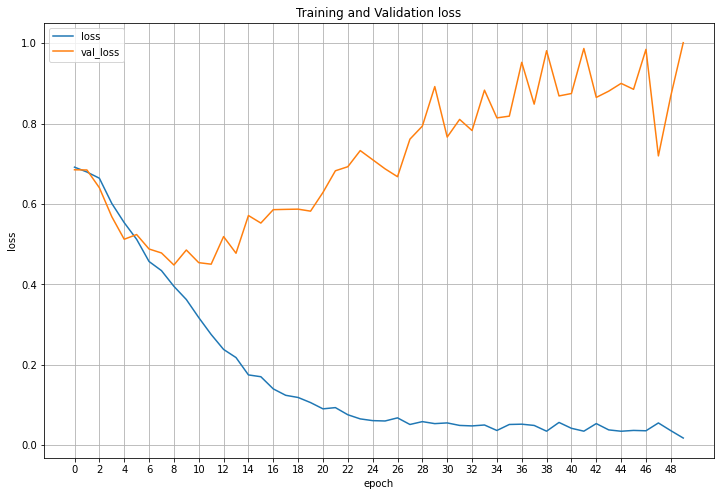

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

hist_df = pd.DataFrame(history.history)
hist_df.plot(y=['loss', 'val_loss'], figsize=(12, 8))
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and Validation loss')
plt.grid(axis='both')
plt.xticks(np.arange(0, 50, 2))
plt.show()

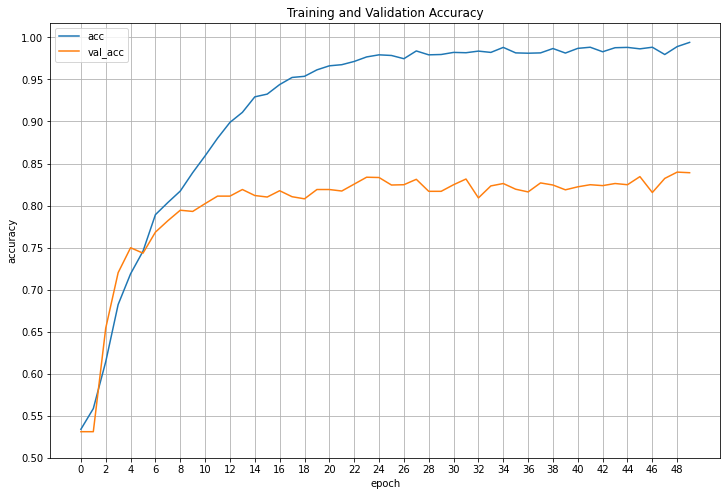

In [18]:
hist_df = pd.DataFrame(history.history)
hist_df.plot(y=['acc', 'val_acc'], figsize=(12, 8))
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Training and Validation Accuracy')
plt.grid(axis='both')
plt.xticks(np.arange(0, 50, 2))
plt.yticks(np.arange(0.5, 1.01, 0.05))
plt.show()

#Testing

In [19]:
model.load_weights('saved-model/best-model')
model.evaluate(X_test, y_test)

64/64 [==============================] - 2s 30ms/step - loss: 0.4416 - acc: 0.7934


[0.4415605068206787, 0.7933761477470398]